In [7]:
from tensorflow.examples.tutorials.mnist import input_data
#载入mnlist数据
mnist=input_data.read_data_sets('D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data',one_hot=True)

#检测是否导入成功
print('Train data size',mnist.train.num_examples)
'''训练数据train 55000个 验证数据validation 5000个 测试数据test 10000个'''
'''其中训练数据 分为两个类，28*28（784）矩阵 和 标签 标签长度为10 表示各个数字'''
#使用batch功能从数据集中读取一小部分作为一个batch
batch_size=100
#从train集合中选取batch_size个数据
xs,ys=mnist.train.next_batch(batch_size)
print('X shape ',xs.shape)
print('Y shape ',ys.shape)

Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\train-images-idx3-ubyte.gz
Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\t10k-labels-idx1-ubyte.gz
Train data size 55000
X shape  (100, 784)
Y shape  (100, 10)


In [14]:
#实例
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#MNIST数据集相关的常数
INPUT_NODE=784#像素
OUTPUT_NODE=10#区分类别数目
#配置神经网络的参数
LAYER1_NODE=500#使用一个隐藏层 500个节点  选取的500比784小
BATCH_SIZE=100#一个训练batch中的训练数据个数

LEARNING_RATE_BASE=0.8#基础学习率
LEARNING_RATE_DECAY=0.99 #学习率衰减率 指数衰减
REGULARIZATION_RATE=0.0001#描述函数模型复杂的的正则化在损失函数中的系数
TRAINING_STEPS=1000#训练轮数
MOVING_AVERAGE_DECAY=0.9#滑动平均衰减率  滑动平均使用

#给定神经网络参数  计算向前传播结果  avg_class为传入的滑动平均类 该类可以使用average方法
def inference(input_tensor,avg_class,weights1,biases1,weights2,biases2):
    #确认是否有滑动类
    if avg_class==None:
        layer1=tf.nn.relu(tf.matmul(input_tensor,weights1)+biases1)#矩阵相乘加偏置 第一层神经网络的输出
        '''其中weight的列数为神经网络节点的个数'''
        #没有加入softmax函数 和激活函数 之后一并加入
        return tf.matmul(layer1,weights2)+biases2
    '''连带输入层，一共三层，而第三层神经元每个节点的值则直接作为输出，输出节点只有10个，之后要经过softmax层'''
    else:
        layer1=tf.nn.relu(tf.matmul(input_tensor,avg_class.average(weights1))+avg_class.average(biases1))
        return tf.matmul(layer1,avg_class.average(weights2))+avg_class.average(biases2)
        #滑动平均类average() 输出值为更新的影子变量值  该变量值与应用的变量 权重系数有关

#定义训练模型的过程
def train(mnist):
    x=tf.placeholder(tf.float32,[None,INPUT_NODE],name='x-input')#输入为一个bacth*784
    y_=tf.placeholder(tf.float32,[None,OUTPUT_NODE],name='y-input')#y_表示真实值
    #随机生成隐藏层的参数
    weights1=tf.Variable(tf.truncated_normal([INPUT_NODE,LAYER1_NODE],stddev=0.1))#正态分布  784*500个系数  500个节点
    '''比如一个样本输入的列数为100列，则第一层可以认为有100个节点，而多个样本则是多次分批输入
    则输入的所有列都要乘上各自的权重，这些权重就是weight的每一列，如所有输入*第一列，得到隐藏层第一个节点的输出。
    而有多少列，则就是有多少个隐藏层节点，也就是中间节点有多少个
    其中weight的列数为神经网络节点的个数'''
    biases1=tf.Variable(tf.constant(0.1,shape=[LAYER1_NODE]))
    weights2=tf.Variable(tf.truncated_normal([LAYER1_NODE,OUTPUT_NODE],stddev=0.1))
    biases2=tf.Variable(tf.constant(0.1,shape=[OUTPUT_NODE]))#传出来一个10列的数列
    
    #计算在当前神经网络下向前传播的结果 不使用参数的滑动平均值
    y=inference(x,None,weights1,biases1,weights2,biases2)

    #定义训练轮数 因为不适应滑动平均值 因此可以指定为不可训练的变量
    global_step=tf.Variable(0,trainable=False)

    #给定滑动平均衰减率和训练轮数 初始化滑动平均类
    variable_averages=tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY,global_step)

    #在所有代表神经网络参数的变量上使用滑动平均  滑动平均维护一个影子变量，程序中直接使用了这个影子变量
    #tf.trainable_variables()返回计算图中可以训练的变量，即trainable=True的参数
    variables_averages_op=variable_averages.apply(tf.trainable_variables())

    #使用滑动平均之后的前向传播结果
    average_y=inference(x,variable_averages,weights1,biases1,weights2,biases2)

    #tf.argmax(y_,1) y_为输入序列 argmax表示选取最大值，其中参数1表示仅在第一个维度中执行，也就是说选取每行中最大值的对应下标
    #y_有多少行 tf.argmax(y_,1)返回一个长度为多少的数组
    #此函数第一个参数y为训练结果，第二个参数为正确答案
    cross_entropy=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,labels=tf.argmax(y_,1))
    '''注意，在这里是使用正常的变量维护来进行  训练  数据，但是使用滑动平均来  测试  训练结果的准确性'''
    '''y这里的取值是一个十维的数组，每个元素取值都可以是0-1之间的小数，此函数大概是寻找这些维度与对应0-9标签之间的联系
    使用softmax层进行优化，计算多分类问题的交叉熵
    交叉熵越小，两个事件发生的概率分布越接近，证明预测值越接近实际值'''
    #求平均
    cross_entropy_mean=tf.reduce_mean(cross_entropy)

    #计算L2正则化损失函数
    regularizer=tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    #计算模型的正则化损失
    regularization=regularizer(weights1)+regularizer(weights2)
    #总损失等交叉熵损失和正则损失和
    loss=cross_entropy_mean+regularization
    #设置指数衰减的学习率   未设置stairacase=True则是连续指数衰减
    learning_rate=tf.train.exponential_decay(
        LEARNING_RATE_BASE,#基础学习率
        global_step,#当前迭代轮数
        mnist.train.num_examples/BATCH_SIZE,#过完所有的训练数据需要的迭代次数
        LEARNING_RATE_DECAY#学习率衰减速度
    )
    #使用优化器  这个优化器的学习率是呈指数衰减的，并且是一个梯度衰减
    train_step=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)

    #既反向传播来更新神经网络参数，又更新每一个滑动平均的值 将滑动平均apply方法绑定到train_op中去
    train_op=tf.group(train_step,variables_averages_op)
    #train_op=train_step

    #检测使用了滑动平均模型的神经网络向前传播结果是否正确
    #tf.argmax(y_,1) y_为输入序列 argmax表示选取最大值，其中参数1表示仅在第一个维度中执行，也就是说选取每行中最大值的对应下标
    #y_有多少行 tf.argmax(y_,1)返回一个长度为多少的数组
    #average_y 模型使用滑动平均后预测向前传播结果 y_正确结果  这里判断两者的每一维(一共10个batch)是否相等，返回True或者False
    correct_prediction=tf.equal(tf.argmax(average_y,1),tf.argmax(y_,1))
    '''这里的average_y算出来是一个十维数组，但是每个元素的值都可以是0-1之间的小数，argmax这里取元素最大值的下标。
    即判断某件为某个标签最大值的概率'''
    #correct_prediction=tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    #初始化会话
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #准备验证数据，可以通过验证数据来大致判断神经网络的停止条件和评判预测效果
        validate_feed={x:mnist.validation.images,
                      y_:mnist.validation.labels}
        #print(validate_feed)
        #准备测试数据
        test_feed={x:mnist.test.images,y_:mnist.test.labels}
        validate_acc_last=1
        #迭代训练数据
        for i in range(TRAINING_STEPS):
            #每100轮输出一次在验证数据上测试结果
            if i %100==0:
                #这里直接一次处理了所有的验证数据  如果要处理一部分验证数据，可以对validate_feed进行切片操作或者.next_batch选取
                validate_acc=sess.run(accuracy,feed_dict=validate_feed)
                print('After %d training step(s),validation accuracy'
                      'using average model is %g'%(i,validate_acc))
                print("增长率%g"%(validate_acc/validate_acc_last))
                validate_acc_last=validate_acc
                
                print("global %g"%(sess.run(global_step)))
            xs,ys=mnist.train.next_batch(BATCH_SIZE)#选取数据
            #print("learn rate%g"%(sess.run(learning_rate)))
            #是否可以加一个for
            for j in range(5):
                sess.run(train_op,feed_dict={x:xs,y_:ys})
            #训练既反向传播，又更新滑动平均值的模型。每次训练都使用的是随机选取的100个数据，但是却是随机选取TRAINING_STEPS次

        test_acc=sess.run(accuracy,feed_dict=test_feed)#accury 为100一个模型的平均正确率
        #打印最终正确率
        print('After %d training step(s),validation accuracy'
                      'using average model is %g'%(TRAINING_STEPS,test_acc))


mnist=input_data.read_data_sets('D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data',one_hot=True)
train(mnist)


            

Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\train-images-idx3-ubyte.gz
Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:/PythonCode/Machine/jupyter1/Tensor/path/to/MNIST_data\t10k-labels-idx1-ubyte.gz
After 0 training step(s),validation accuracyusing average model is 0.0786
增长率0.0786
global 0
After 100 training step(s),validation accuracyusing average model is 0.9532
增长率12.1272
global 500
After 200 training step(s),validation accuracyusing average model is 0.9616
增长率1.00881
global 1000
After 300 training step(s),validation accuracyusing average model is 0.9642
增长率1.0027
global 1500
After 400 training step(s),validation accuracyusing average model is 0.9678
增长率1.00373
global 2000
After 500 training step(s),validation accuracyusing average model is 0.971
增长率1.00331
global 2500
After 600 training step(s),validation

# 采用滑动平均数据验证数据
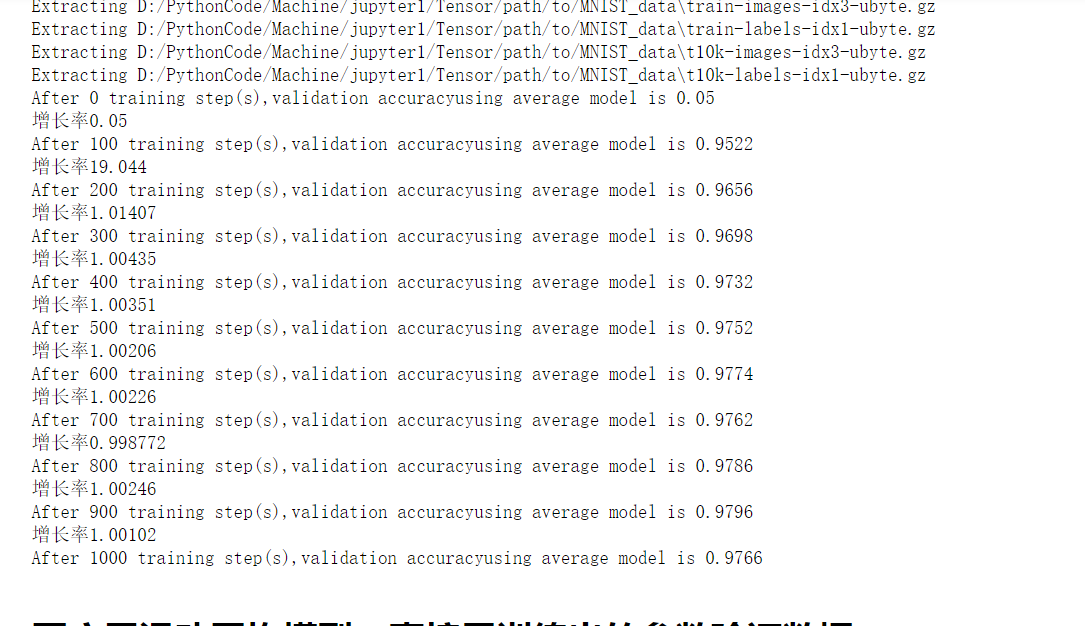

可以看到200次后1.014

# 修改滑动平均参数由0.99->0.5

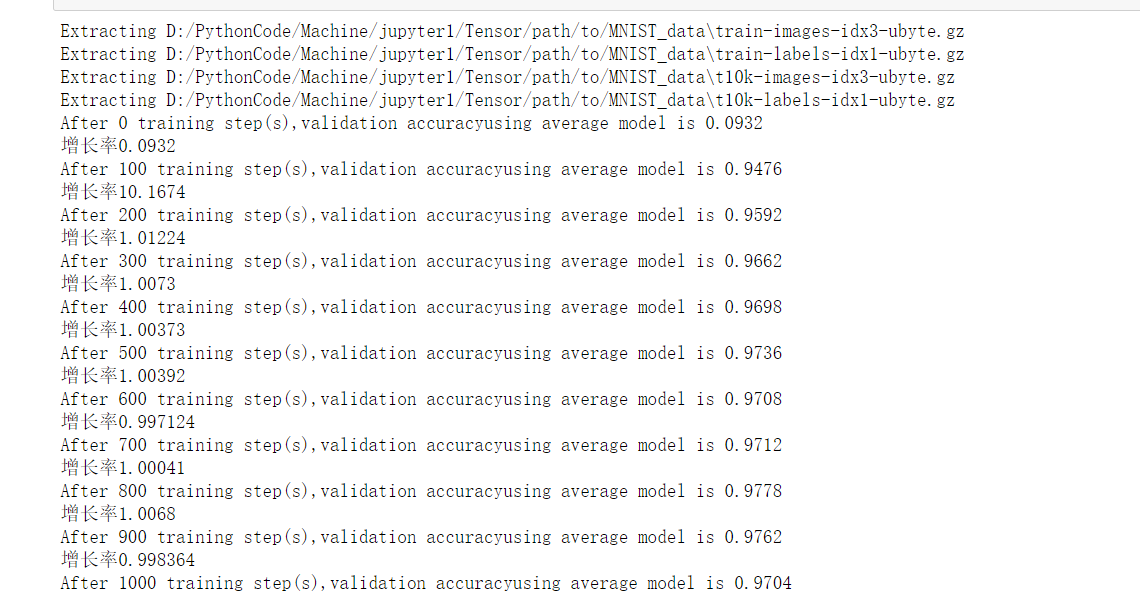

# 变更滑动平均参数由0.5->0.9
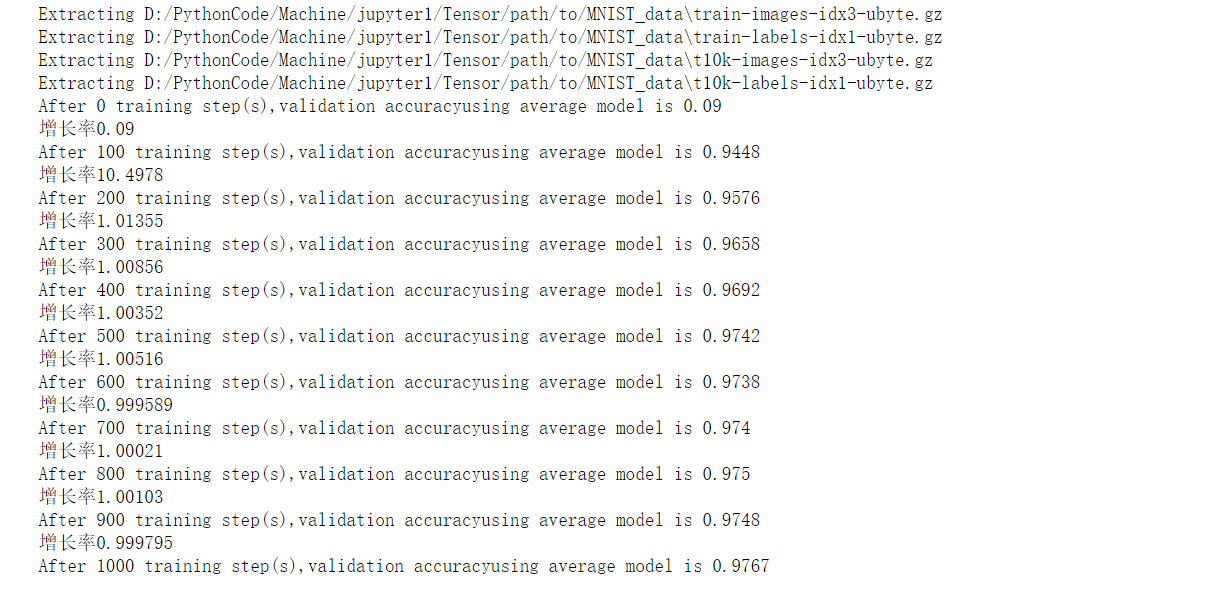

# 直接采用训练出的变量来应用于验证，查看效果
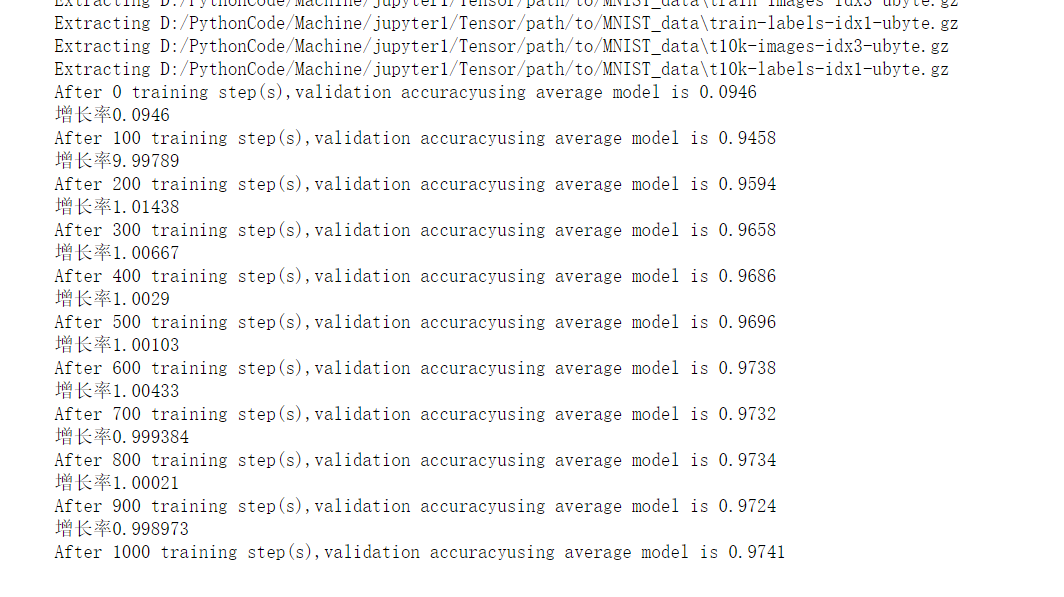

In [17]:
#理解global_step含义
import tensorflow as tf
v1=tf.Variable(0,dtype=tf.float32)
step=tf.Variable(0,trainable=False)
ema=tf.train.ExponentialMovingAverage(0.99,step)

maintain_averages_op=ema.apply([v1])
with tf.Session() as sess:
    init_op=tf.global_variables_initializer()
    sess.run(init_op)
    print(sess.run(step))
    
    sess.run(tf.assign(v1,5))
    sess.run(maintain_averages_op)
    print(sess.run(step))
    
    
    sess.run(tf.assign(v1,1))
    sess.run(maintain_averages_op)
    print(sess.run(step))


0
0
0


In [1]:
import tensorflow as tf
#在名为foo的命名空间中创建名字为v的变量
with tf.variable_scope('foo'):
    v=tf.get_variable('v',[1],initializer=tf.constant_initializer(1.0))
    #get_variable创建名为v shape=[1] 初始化值为1.0的变量 initializer参数可以不要
'''
#会报错 因为重复get
with tf.variable_scope('foo'):
    v1=tf.get_variable('v',[1])
'''

with tf.variable_scope('foo',reuse=True):#设置参数reuse 这样get方法只能获得已经申明的变量
    v1=tf.get_variable('v',[1])
print((foo/v1)==v)
'''
#如果再次使用
#因为get方法只能获得已经申明的变量,而bar不存在故 报错
with tf.variable_scope('foo',reuse=False):
    v1=tf.get_variable('bar',[1])

'''

NameError: name 'foo' is not defined

In [3]:
#保存tensorflow计算图
import tensorflow as tf
#声明两个变量并计算和
v1=tf.Variable(tf.constant(1.0,shape=[1],name='v1'))
v2=tf.Variable(tf.constant(1.0,shape=[1],name='v2'))
result=v1+v2
init_op=tf.global_variables_initializer()

#声明tf.train.Saver()类用于保存模型
saver=tf.train.Saver()

with tf.Session() as sess:
    sess.run(init_op)
    #将模型保存到文件中
    saver.save(sess,'D:/PythonCode/Machine/jupyter1/Tensor/saver/model.ckpt')

In [4]:
#加载已保存的计算图
#保存tensorflow计算图
import tensorflow as tf
#声明两个变量并计算和
v1=tf.Variable(tf.constant(1.0,shape=[1],name='v1'))
v2=tf.Variable(tf.constant(1.0,shape=[1],name='v2'))
result=v1+v2
init_op=tf.global_variables_initializer()

saver=tf.train.Saver()
with tf.Session() as sess:
    #不需要运行模型的初始化过程
    #加载已保存的模型，并通过已保存的模型中变量的值来计算加法
    saver.restore(sess,'D:/PythonCode/Machine/jupyter1/Tensor/saver/model.ckpt')
    print(sess.run(result))

INFO:tensorflow:Restoring parameters from D:/PythonCode/Machine/jupyter1/Tensor/saver/model.ckpt


NotFoundError: Key Variable_3 not found in checkpoint
	 [[Node: save_1/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_3/tensor_names, save_1/RestoreV2_3/shape_and_slices)]]

Caused by op 'save_1/RestoreV2_3', defined at:
  File "H:\Anaconda\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "H:\Anaconda\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "H:\Anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "H:\Anaconda\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "H:\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "H:\Anaconda\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "H:\Anaconda\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "H:\Anaconda\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "H:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "H:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "H:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "H:\Anaconda\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "H:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "H:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "H:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "H:\Anaconda\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "H:\Anaconda\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "H:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "H:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "H:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-ac59c05a0746>", line 10, in <module>
    saver=tf.train.Saver()
  File "H:\Anaconda\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "H:\Anaconda\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "H:\Anaconda\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "H:\Anaconda\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "H:\Anaconda\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "H:\Anaconda\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "H:\Anaconda\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "H:\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "H:\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key Variable_3 not found in checkpoint
	 [[Node: save_1/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_3/tensor_names, save_1/RestoreV2_3/shape_and_slices)]]
